Коэффициенты усиления LQR: [ -31.6227766   -29.68104308 -131.79167487  -30.3640613 ]


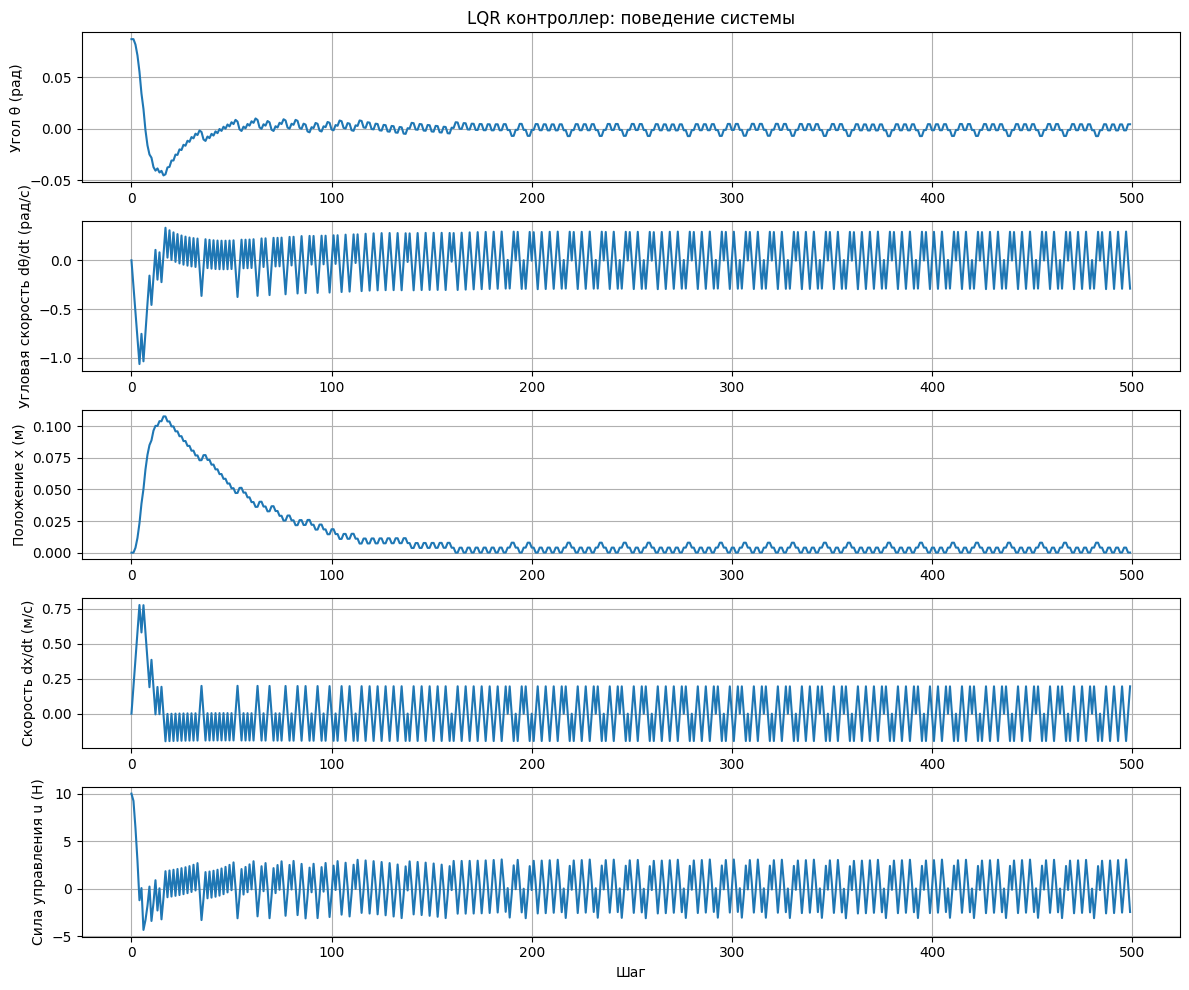

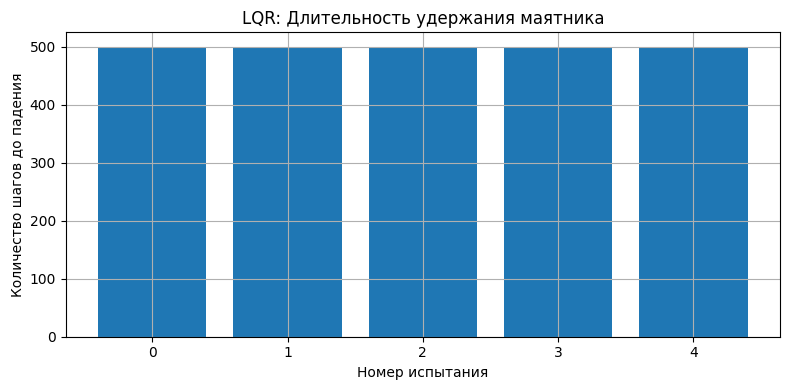

MSE для угла θ: 0.000122
MSE для положения x: 0.000752
Затраченная энергия: 2143.05
Среднее количество шагов до падения: 500.00 ± 0.00


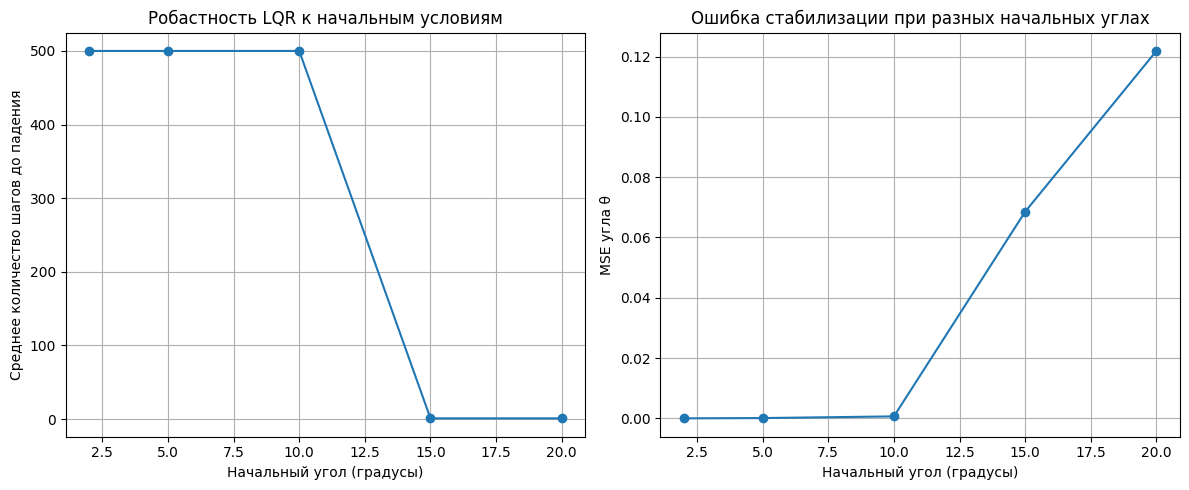

In [2]:
import gym
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import time
import pandas as pd
from collections import defaultdict

np.bool8 = np.bool_

# Создаем среду CartPole
env = gym.make("CartPole-v1", render_mode=None)  # Сначала без рендеринга для сбора данных

# Параметры системы
g = 9.8
m = 0.1     # масса маятника
M = 1.0     # масса тележки
L = 0.5     # длина до центра масс
dt = 0.02   # шаг интегрирования

# Линейная модель около вертикального положения
A = np.array([
    [0, 1, 0, 0],
    [0, 0, - (m * g) / M, 0],
    [0, 0, 0, 1],
    [0, 0, (g * (m + M)) / (L * M), 0]
])
B = np.array([[0], [1 / M], [0], [-1 / (L * M)]])

# Функционал LQR
Q = np.diag([10, 1, 10, 1])  # Штраф на отклонение состояния
R = np.array([[0.01]])      # Штраф на управление

# Решаем матричное уравнение Риккати
P = linalg.solve_continuous_are(A, B, Q, R)

# Вычисляем усиления
K = np.dot(np.linalg.inv(R), B.T @ P)
print(f"Коэффициенты усиления LQR: {K.flatten()}")

# Функция для сбора данных о работе контроллера
def collect_lqr_data(initial_angle=5, trials=5, steps=500):
    data = {
        'trial': [], 'step': [], 'x': [], 'x_dot': [], 
        'theta': [], 'theta_dot': [], 'action': [], 'force': []
    }
    
    trial_lengths = []
    
    for trial in range(trials):
        # Сброс среды
        obs, _ = env.reset()
        
        # Установка начального угла (в градусах)
        custom_state = np.array([0.0, 0.0, np.deg2rad(initial_angle), 0.0])
        env.unwrapped.state = custom_state.copy() 
        obs = custom_state.copy()
        
        for step in range(steps):
            x, x_dot, theta, theta_dot = obs
            state = np.array([[x], [x_dot], [theta], [theta_dot]])
            
            # Управление через LQR (u = -Kx)
            u = -K @ state
            force = float(np.clip(u[0, 0], -10, 10))
            
            # Преобразуем силу в дискретное действие
            action = 0 if force < 0 else 1
            
            # Выполняем шаг
            obs, reward, terminated, truncated, _ = env.step(action)
            
            # Сохраняем данные
            data['trial'].append(trial)
            data['step'].append(step)
            data['x'].append(x)
            data['x_dot'].append(x_dot)
            data['theta'].append(theta)
            data['theta_dot'].append(theta_dot)
            data['action'].append(action)
            data['force'].append(force)
            
            if terminated or truncated:
                trial_lengths.append(step + 1)
                break
                
        if len(trial_lengths) <= trial:
            trial_lengths.append(steps)
    
    # Преобразуем данные в DataFrame
    df = pd.DataFrame(data)
    return df, trial_lengths

# Визуализация работы LQR контроллера
def visualize_lqr_performance(df, trial_lengths, save_path=None):
    # Выберем данные первого прогона для графиков
    trial_data = df[df['trial'] == 0]
    
    # Создаем фигуру
    fig, axs = plt.subplots(5, 1, figsize=(12, 10))
    
    # Угол отклонения маятника
    axs[0].plot(trial_data['step'], trial_data['theta'])
    axs[0].set_ylabel('Угол θ (рад)')
    axs[0].set_title('LQR контроллер: поведение системы')
    axs[0].grid(True)
    
    # Угловая скорость маятника
    axs[1].plot(trial_data['step'], trial_data['theta_dot'])
    axs[1].set_ylabel('Угловая скорость dθ/dt (рад/с)')
    axs[1].grid(True)
    
    # Положение тележки
    axs[2].plot(trial_data['step'], trial_data['x'])
    axs[2].set_ylabel('Положение x (м)')
    axs[2].grid(True)
    
    # Скорость тележки
    axs[3].plot(trial_data['step'], trial_data['x_dot'])
    axs[3].set_ylabel('Скорость dx/dt (м/с)')
    axs[3].grid(True)
    
    # Управляющее воздействие
    axs[4].plot(trial_data['step'], trial_data['force'])
    axs[4].set_xlabel('Шаг')
    axs[4].set_ylabel('Сила управления u (Н)')
    axs[4].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()
    
    # Показать статистику по длительности испытаний
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(trial_lengths)), trial_lengths)
    plt.xlabel('Номер испытания')
    plt.ylabel('Количество шагов до падения')
    plt.title('LQR: Длительность удержания маятника')
    plt.grid(True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path.replace('.png', '_trials.png'))
    plt.show()
    
    # Расчет статистик
    mse_theta = np.mean(trial_data['theta']**2)
    mse_x = np.mean(trial_data['x']**2)
    energy = np.sum(trial_data['force']**2)
    
    print(f"MSE для угла θ: {mse_theta:.6f}")
    print(f"MSE для положения x: {mse_x:.6f}")
    print(f"Затраченная энергия: {energy:.2f}")
    print(f"Среднее количество шагов до падения: {np.mean(trial_lengths):.2f} ± {np.std(trial_lengths):.2f}")

# Собираем данные для LQR
lqr_data, lqr_trial_lengths = collect_lqr_data(initial_angle=5, trials=5)

# Визуализируем результаты
visualize_lqr_performance(lqr_data, lqr_trial_lengths, save_path="lqr_performance.png")

# Демонстрация с рендерингом
def demonstrate_lqr(initial_angle=5, steps=200):
    env_render = gym.make("CartPole-v1", render_mode="human")
    obs, _ = env_render.reset()
    
    # Установка начального угла (в градусах)
    custom_state = np.array([0.0, 0.0, np.deg2rad(initial_angle), 0.0])
    env_render.unwrapped.state = custom_state.copy()
    obs = custom_state.copy()
    
    for step in range(steps):
        x, x_dot, theta, theta_dot = obs
        state = np.array([[x], [x_dot], [theta], [theta_dot]])
        
        # Управление через LQR (u = -Kx)
        u = -K @ state
        force = float(np.clip(u[0, 0], -10, 10))
        
        # Преобразуем силу в дискретное действие
        action = 0 if force < 0 else 1
        
        # Выполняем шаг
        obs, reward, terminated, truncated, _ = env_render.step(action)
        env_render.render()
        time.sleep(0.02)  # Замедлим для лучшей визуализации
        
        if terminated or truncated:
            break
    
    env_render.close()

# Запуск демонстрации LQR (раскомментируйте при необходимости)
# demonstrate_lqr(initial_angle=10)

# Тест на робастность - различные начальные углы
def test_robustness_initial_angles(angles=None):
    if angles is None:
        angles = [2, 5, 10, 15, 20]
    
    results = []
    
    for angle in angles:
        data, trial_lengths = collect_lqr_data(initial_angle=angle, trials=3)
        avg_length = np.mean(trial_lengths)
        mse_theta = np.mean(data[data['trial'] == 0]['theta']**2)
        
        results.append({
            'angle': angle,
            'avg_steps': avg_length,
            'mse_theta': mse_theta
        })
    
    # Создаем графики
    results_df = pd.DataFrame(results)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(results_df['angle'], results_df['avg_steps'], 'o-')
    ax1.set_xlabel('Начальный угол (градусы)')
    ax1.set_ylabel('Среднее количество шагов до падения')
    ax1.set_title('Робастность LQR к начальным условиям')
    ax1.grid(True)
    
    ax2.plot(results_df['angle'], results_df['mse_theta'], 'o-')
    ax2.set_xlabel('Начальный угол (градусы)')
    ax2.set_ylabel('MSE угла θ')
    ax2.set_title('Ошибка стабилизации при разных начальных углах')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig("lqr_robustness.png")
    plt.show()
    
    return results_df

# Тест на робастность
robustness_results = test_robustness_initial_angles()

# Завершение
env.close()